# Example of operational forecast with Clyfar
This is how to generate a forecast from Clyfar.

This requires:
* DATA - Current observations of snow depth to initialise the input value
* FORECAST DATA - Forecasts of MSLP, wind speed, solar radiation, and snow depth (differences between initial depth and forecasted depth gives actual depth as representative forecast value). There are **30** ensemble members for each forecast so we have 30 instances of Clyfar
* MEMBERSHIPS - Membership functions defined for four inputs and one output (ozone)
* RULES - Rules defined, currently 6
* DEFUZZIFICATION - Defuzzification method for worst-, best-, average-case scenarios. The use can lean towards that side of the forecast envelope the more they are risk-averse.
* POSSIBILITY DISTRIBUTION - Bars of possibility of ozone, plus an unsure parameter

Gotchas:
* Solar radiation needs initialising with a few days from the representative observation to do the moving-window smoothing that optimised forecasts (damping signal of clouds etc and allowing more of the signal of the sun's position to come through)
* I'm still deciding where to reduce the dimension of ensemble members to a single number. At this point it is a third-order uncertainty when we have ensemble-generated distributions of possibilities: upper bounds of probabilities!
* It can take 7 hours for all data to go online so we should time the Clyfar runs tactically. (after 6am UTC-7 to access the 12Z run is a good time)

Future work (some in progress)
* Better ways of reducing grid points to a single number per ensemble member (e.g., subsetting geographically to a central point in the basin)
* MSLP especially seems dominated by bias error: an easier correction to make than overall error
* Create a nice package and DOI for v.1.0 but keep improving versions as Ozone Alert progresses (features and bugs)
* Rule 7: low-possibility long tail for extreme ozone fuzzy set covered in rules by allowing gusty wind but keeping other parameters conducive for extreme ozone. This is advised by Seth's observation that there is a day lag in inversion mix-out with wind increase (is this sensitive to how we compute ozone? Lowest from west to east?)
* Look at timezone conversions to make sure we convert versus change label, plus whether subtracting seven hours from UTC puts a representative observation into the wrong (previous) day.

Stuff for version 2.0
* Deep learning for parameters
* Use of more models like HRRR (lagged ensembles) and NAM
* Use of more observations like satellite data
* Temperature advection from GJT and SLC soundings at 700 hPa (WAA)
* Forecast temperature to see if surface parcels can escape inversion (need cap strength)


In [1]:
import importlib
import datetime

import pandas as pd
import pytz
import numpy as np
import matplotlib.pyplot as plt

import xarray as xr

from utils.geog_funcs import elevation_from_latlon
from utils.lookups import (
    elevations,
    snow_stids,
    wind_stids,
    solar_stids,
    mslp_stids,
    ozone_stids,
    Lookup,
)
from nwp.gefsdata import GEFSData
import utils.utils as utils
from utils.utils import datetime_of_previous_run
from nwp.gefsdata import GEFSData
from nwp.download_funcs import load_variable, check_and_create_latlon_files
from obs.download_winters import download_most_recent
from utils.geog_funcs import get_elevations_for_resolutions
from preprocessing.representative_nwp_values import (
    create_forecast_dataframe,
    get_latlon_timeseries_df,
    get_grid_timeseries,
    do_nwpval_snow, do_nwpval_mslp, do_nwpval_wind, do_nwpval_solar,
)
from preprocessing.representative_obs import (
    get_representative_obs,
)
from viz.plotting import plot_meteogram

/Users/johnlawson/anaconda3/envs/clyfar/lib/python3.11/site-packages/synoptic/accessors.py:28: UserWarning: map making not available without Brian's cartopy_tools
  warnings.warn("map making not available without Brian's cartopy_tools")


In [2]:
# CONSTANTS / SETTINGS

############### GEOGRAPHY INFO ################

LATLONS = {
    '0p25': check_and_create_latlon_files("0p25"),
    '0p5': check_and_create_latlon_files("0p5")
}

elev_df = {'0p25': None, '0p5': None}
for res in elev_df.keys():
    elev_df[res] = get_elevations_for_resolutions(LATLONS, res, fdir='data')

masks = dict()
for res in ['0p25', '0p5']:
    masks[res] = elev_df[res] < 2000

my_extent = [-110.9, -108.2, 41.3, 39.2]

remove_grib = False

# This is a "centre" point for sampling NWP
ouray = {'lat': 40.0891, 'lon': -109.6774}

################ FORECAST INFO ################
member_names = ['c00',] + [f'p{n:02d}' for n in range(1, 31)]

# Skipping control member and picking a few perturbation for testing
member_names = member_names[1:5]

# Lookup tables for variables
# TODO - eventually move all to this Lookup class
L = Lookup()

PRODUCTS = {'solar': "atmos.25", 'snow': "atmos.25", 'mslp': "atmos.25",
                'wind': "atmos.25"}
PRODUCTS_BKUP = {'solar': "atmos.5", 'snow': "atmos.5", 'mslp': "atmos.5",
                    'wind': "atmos.5"}
LABELS = {'solar': 'Solar radiation (W/m^2)', 'snow': 'Snow depth (m)',
            'mslp': 'Mean sea level pressure (hPa)', 'wind': 'Wind speed (m/s)',
            'ozone': 'Ozone concentration (ppb)'}

STIDS = {"snow": snow_stids, "wind": wind_stids,
         "solar": solar_stids, "mslp": mslp_stids,
         "ozone": ozone_stids}

######################### TIME #########################
# Step in forecast time series requested
# TODO - parallelise operations so we can use 3-h data for better DSWRF estiamtes
delta_h = 12

# Maximum forecast time (hours) for each resolution
max_h = {"0p25":240, "0p5":384}



In [3]:
#######################################################################
###################### DATA STRUCTURES ################################
#######################################################################

# Obs, dataframes, etc for each variable
OBS = {}
DFS = {}
vrbl_names = {'solar': 'solar_radiation', 'snow': 'snow_depth',
              'wind': 'wind_speed', 'mslp': 'sea_level_pressure',
              'ozone': 'ozone_concentration'}

repr_vals = {}

In [4]:
INIT_DT = utils.get_valid_forecast_init(force_init_dt=datetime.datetime(2024, 12, 3, 6, 0, 0))

In [5]:
utils.print_forecast_init_times(INIT_DT)

Current datetime in UTC: 2024-12-04 08:59:46.437791+00:00
Forecast initialization time (UTC): 2024-12-03 06:00:00+00:00
Forecast initialization time (naive, no timezone): 2024-12-03 06:00:00
Forecast initialization time (local, US/Mountain): 2024-12-03 06:00:00-07:00
Skipped initialization times (most recent runs):


In [6]:
vrbl = "solar"
repr_vals[vrbl] = get_representative_obs(vrbl, 7, STIDS[vrbl])
repr_vals[vrbl]
# TODO - not sure if this is today or yesterday...


 🚚💨 Speedy Delivery from Synoptic API [metadata]: https://api.synopticdata.com/v2/stations/metadata?stid=A1622,SPMU1,SFLU1,E3712,UTSTV,USWU1,MCKU1&token=🙈HIDDEN

Loading data for station A1622


/Users/johnlawson/anaconda3/envs/clyfar/lib/python3.11/site-packages/synoptic/services.py:525: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors="ignore")


Loading data for station SPMU1
Loading data for station SFLU1
Loading data for station E3712
Loading data for station UTSTV
Loading data for station USWU1
Loading data for station MCKU1


,solar_radiation
2024-11-27,NaN
2024-11-28,NaN
2024-11-29,NaN
2024-11-30,465.96875
2024-12-01,479.68750
2024-12-02,471.34375
2024-12-03,467.03125


In [7]:
vrbl = "mslp"
repr_vals[vrbl] = get_representative_obs(vrbl, 7, STIDS[vrbl])/100 # hPa
repr_vals[vrbl]


 🚚💨 Speedy Delivery from Synoptic API [metadata]: https://api.synopticdata.com/v2/stations/metadata?stid=KVEL&token=🙈HIDDEN

Loading data for station KVEL


/Users/johnlawson/anaconda3/envs/clyfar/lib/python3.11/site-packages/synoptic/services.py:525: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors="ignore")


,sea_level_pressure
date,
2024-11-28,1023.474609
2024-11-29,1030.274648
2024-11-30,1031.351367
2024-12-01,1033.186797
2024-12-02,1035.408555
2024-12-03,1036.393281
2024-12-04,1033.657500
2024-12-05,1034.621094


In [8]:
vrbl = 'snow'
repr_vals[vrbl] = get_representative_obs(vrbl, 7, STIDS[vrbl])
repr_vals[vrbl]


 🚚💨 Speedy Delivery from Synoptic API [metadata]: https://api.synopticdata.com/v2/stations/metadata?stid=COOPJENU1,COOPFTDU1,COOPALMU1,COOPDINU1,COOPROSU1,COOPVELU1,COOPDSNU1,COOPOURU1,COOPNELU1&token=🙈HIDDEN

Loading data for station COOPJENU1


/Users/johnlawson/anaconda3/envs/clyfar/lib/python3.11/site-packages/synoptic/services.py:525: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors="ignore")


Loading data for station COOPFTDU1
Loading data for station COOPALMU1
Loading data for station COOPDINU1
Loading data for station COOPROSU1
Loading data for station COOPVELU1
Loading data for station COOPDSNU1
Loading data for station COOPOURU1
Skipping COOPOURU1
Loading data for station COOPNELU1


,snow_depth
date,
2024-11-28,15.25016
2024-11-29,0.01905
2024-11-30,0.01905
2024-12-01,0.00000
2024-12-02,0.00000
2024-12-03,0.00000
2024-12-04,0.00000


In [9]:
vrbl = 'wind'
repr_vals[vrbl] = get_representative_obs(vrbl, 7, STIDS[vrbl])
repr_vals[vrbl]


 🚚💨 Speedy Delivery from Synoptic API [metadata]: https://api.synopticdata.com/v2/stations/metadata?stid=DURU1,A1622,SPMU1,QV4,WAXU1,E8302,KVEL,QRS,MYT5&token=🙈HIDDEN

Loading data for station DURU1


/Users/johnlawson/anaconda3/envs/clyfar/lib/python3.11/site-packages/synoptic/services.py:525: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors="ignore")


Skipping DURU1
No data for DURU1
Loading data for station A1622
Loading data for station SPMU1
Loading data for station QV4
Loading data for station WAXU1
Skipping WAXU1
Loading data for station E8302
Skipping E8302
Loading data for station KVEL
Loading data for station QRS
Loading data for station MYT5
Skipping MYT5


,wind_speed
date,
2024-11-28,2.077000
2024-11-29,2.480750
2024-11-30,2.479750
2024-12-01,2.727000
2024-12-02,2.132500
2024-12-03,2.336750
2024-12-04,2.470500
2024-12-05,1.296875


In [10]:
# TODO get ozone repr value both verification and initialise/add memory?
vrbl = 'ozone'
repr_vals[vrbl] = get_representative_obs(vrbl, 7, STIDS[vrbl])
repr_vals[vrbl]


 🚚💨 Speedy Delivery from Synoptic API [metadata]: https://api.synopticdata.com/v2/stations/metadata?stid=QV4,QRS&token=🙈HIDDEN

Loading data for station QV4


/Users/johnlawson/anaconda3/envs/clyfar/lib/python3.11/site-packages/synoptic/services.py:525: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors="ignore")


Loading data for station QRS


date
2024-11-28    37.7900
2024-11-29    35.9777
2024-11-30    33.5323
2024-12-01    38.7323
2024-12-02    40.7122
2024-12-03    34.5542
2024-12-04    35.9800
Name: ozone_concentration, dtype: float64

# Get the data for the forecast

Things to consider in future:
* Parallel processing of the ensemble members to speed up the forecast


# Wind

Processing member p01
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/Users/johnlawson/data/gefs/20241203]
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F12 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F24 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F48 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F60 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F72 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F84 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F96 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F108 

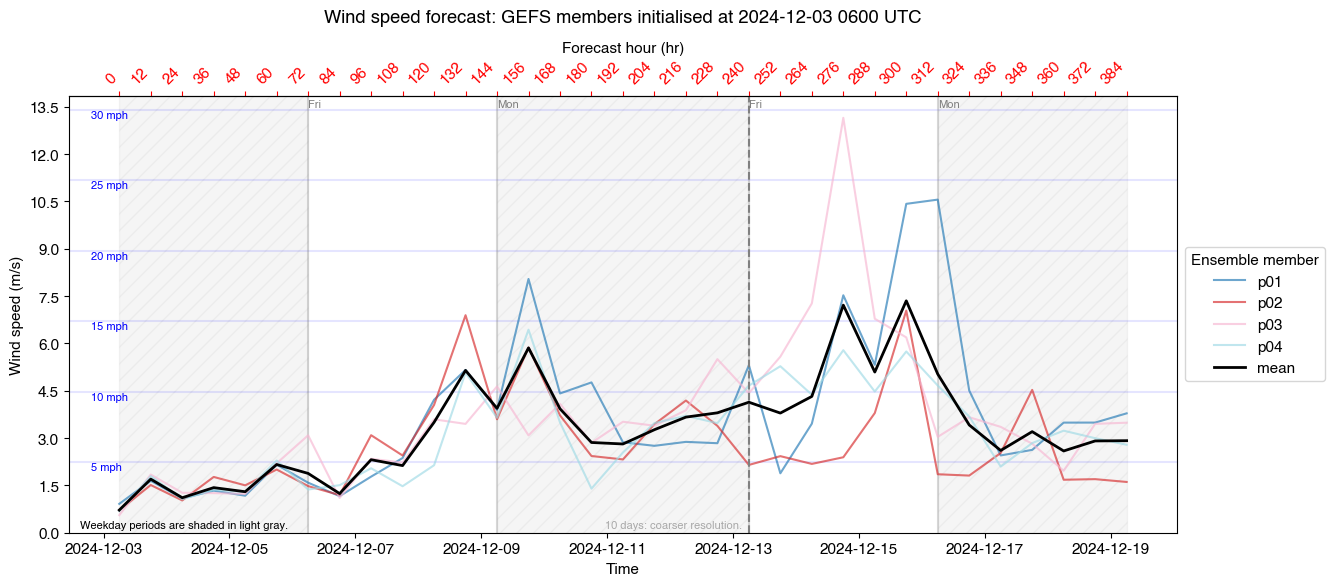

In [11]:
vrbl = 'wind'
dfs_wind = {m:0 for m in member_names}
for member in member_names:
    print(f"Processing member {member}")
    wind_ts = do_nwpval_wind(INIT_DT['naive'], masks, delta_h, quantile=0.9, member=member)
    dfs_wind[member] = create_forecast_dataframe(wind_ts, L.string_dict[vrbl]["array_name"],)

print(f"Completed computing representative {vrbl} forecasts. Now plotting.")
title = (f"Wind speed forecast: GEFS members initialised at "
         f"{dfs_wind[member_names[0]].index[0].strftime('%Y-%m-%d %H%M')} UTC")
fig,ax = plot_meteogram(dfs_wind, L.get_key(vrbl,"array_name"), title=title,
                            plot_ensemble_mean=True)


# Snow
This one is hard because the initial value needs initialising with the representative observed value. Also, we need to choose a subset near the basin floor.

Processing member p01
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F12 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F24 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F48 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F60 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F72 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F84 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F96 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F108 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.

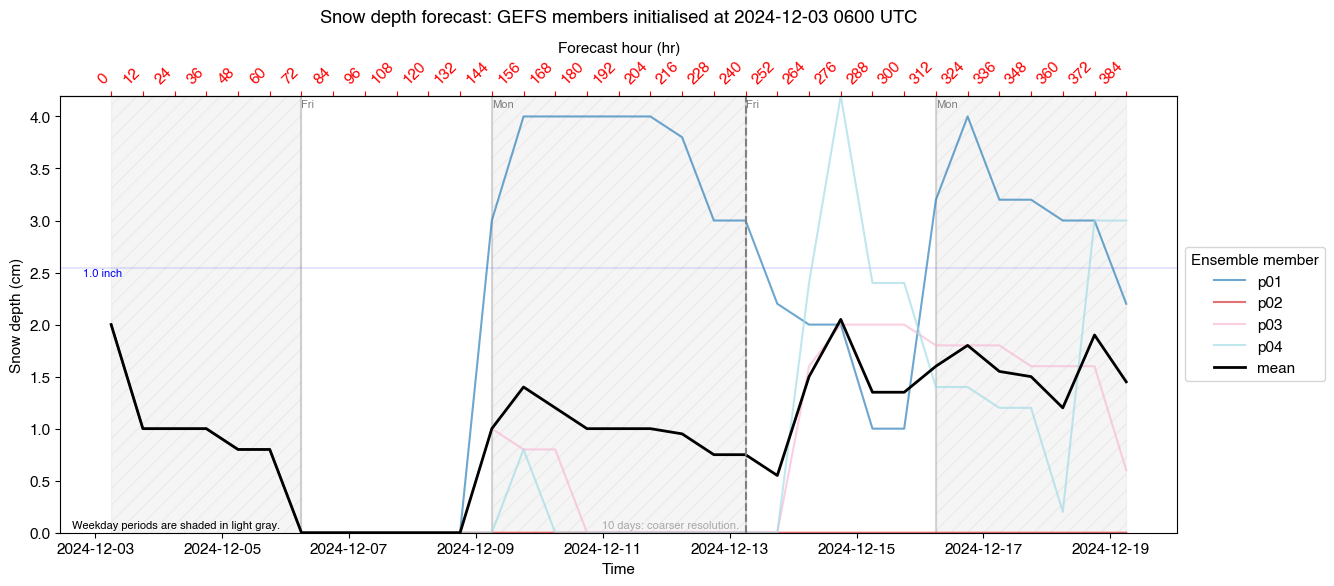

In [12]:
vrbl = "snow"

dfs_snow = {m:0 for m in member_names}
for member in member_names:
    print(f"Processing member {member}")
    snow_ts = do_nwpval_snow(INIT_DT['naive'], masks, delta_h, quantile=0.9, member=member)
    dfs_snow[member] = create_forecast_dataframe(snow_ts, L.string_dict["snow"]["array_name"],)

print(f"Completed computing representative {vrbl} forecasts. Now plotting.")
title = (f"Snow depth forecast: GEFS members initialised at "
         f"{dfs_snow[member_names[0]].index[0].strftime('%Y-%m-%d %H%M')} UTC")

fig,ax = plot_meteogram(dfs_snow, L.get_key(vrbl,"array_name"), title=title,
                            plot_ensemble_mean=True)

# Solar Radiation

Processing member p01
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F03 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F09 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F12 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F15 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F18 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F21 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F24 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F27 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F30 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.2

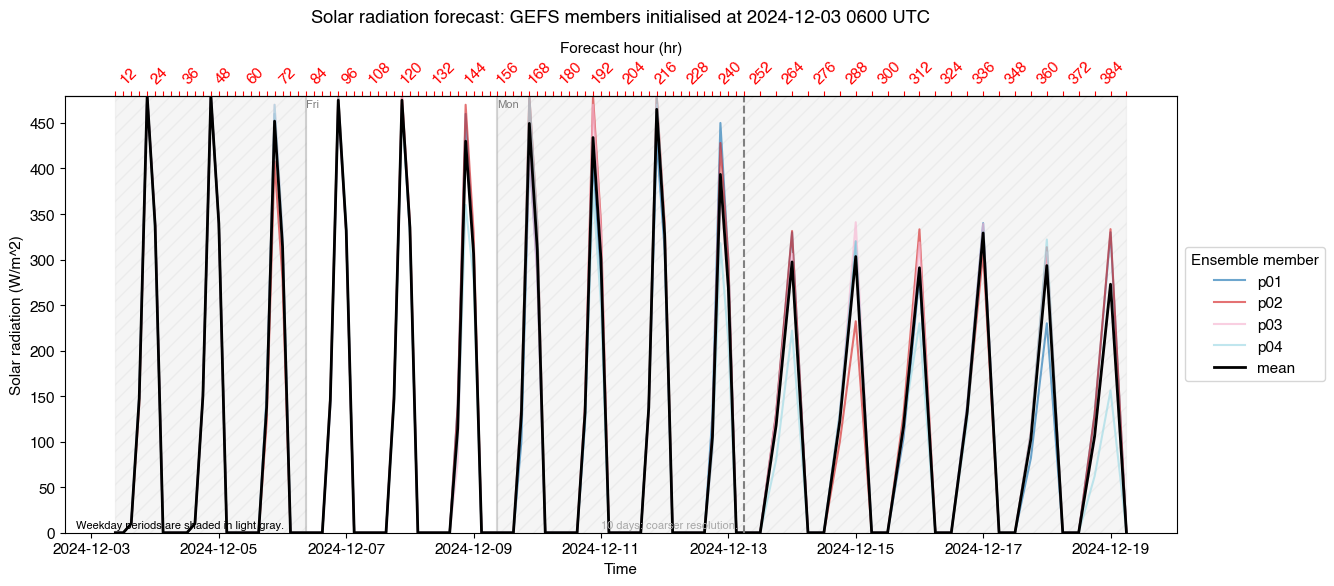

In [13]:
vrbl = 'solar'
dfs_solar = {m:0 for m in member_names}

# More frequent delta_h for solar so we can capture a six-hour window near solar noon
solar_delta_h = 3
for member in member_names:
    print(f"Processing member {member}")
    # TODO - is this doing the percentile before merging?
    # I am worried we are losing the finer resolution when merging
    # We only want to merge final scalar values for time series
    solar_ts = do_nwpval_solar(INIT_DT['naive'], masks, delta_h=solar_delta_h,
                                    quantile=0.9, member=member,)
    dfs_solar[member] = create_forecast_dataframe(solar_ts, L.get_key(vrbl,"array_name"),
                                                    # add_h_init_time=solar_delta_h
                                                    init_time=INIT_DT['naive'],
                                                    )

first_index_dt = dfs_solar[member_names[0]].index[0]
pretty_idx0_str = f"{first_index_dt.strftime('%Y-%m-%d %H%M')}"
pretty_init_str = INIT_DT['naive'].strftime('%Y-%m-%d %H%M')
print(f"This time series began at", pretty_idx0_str, "while initialisation was at",
        pretty_init_str)

# TODO - in process of concat, are we losing the finer resolution at earlier times?
# Make sure we reduce dimensionality to a single number per ensemble member before that

print(f"Completed computing representative {vrbl} forecasts. Now plotting.")
title = (f"Solar radiation forecast: GEFS members initialised at "
         f"{pretty_init_str} UTC")
fig,ax = plot_meteogram(dfs_solar, L.get_key(vrbl,"array_name"), title=title,
                            plot_ensemble_mean=True)

In [14]:
dfs_solar[member_names[0]]

,sdswrf,fxx
time,,
2024-12-03 09:00:00,0.0,3
2024-12-03 12:00:00,0.0,6
2024-12-03 15:00:00,10.0,9
2024-12-03 18:00:00,150.0,12
2024-12-03 21:00:00,480.0,15
...,...,...
2024-12-18 06:00:00,0.0,360
2024-12-18 12:00:00,0.0,366
2024-12-18 18:00:00,130.0,372


# MSLP
#### This is a time series from the nearest cell to Ouray (lowest "error" in reduction to sea level)
The values from GEFS are very similar for each grid point, unsurpringly, but we will still only take the 9-cell mean closest to Ouray (for 0.25 deg) or just Ouray's grid box (for 0.5 degree)

Processing member p01
Getting mslp at lat 40.0891, lon -109.6774 for 2024-12-03 06:00:00
First, get the time series for the 0p25 degree resolution
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F12 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F24 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F48 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F60 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F72 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F84 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2024-Dec-03 06:00 UTC F96 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found

/Users/johnlawson/PycharmProjects/clyfar/viz/plotting.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dict[k][vrbl_col] = v[vrbl_col] * vrbl_factors.get(vrbl_col, 1)


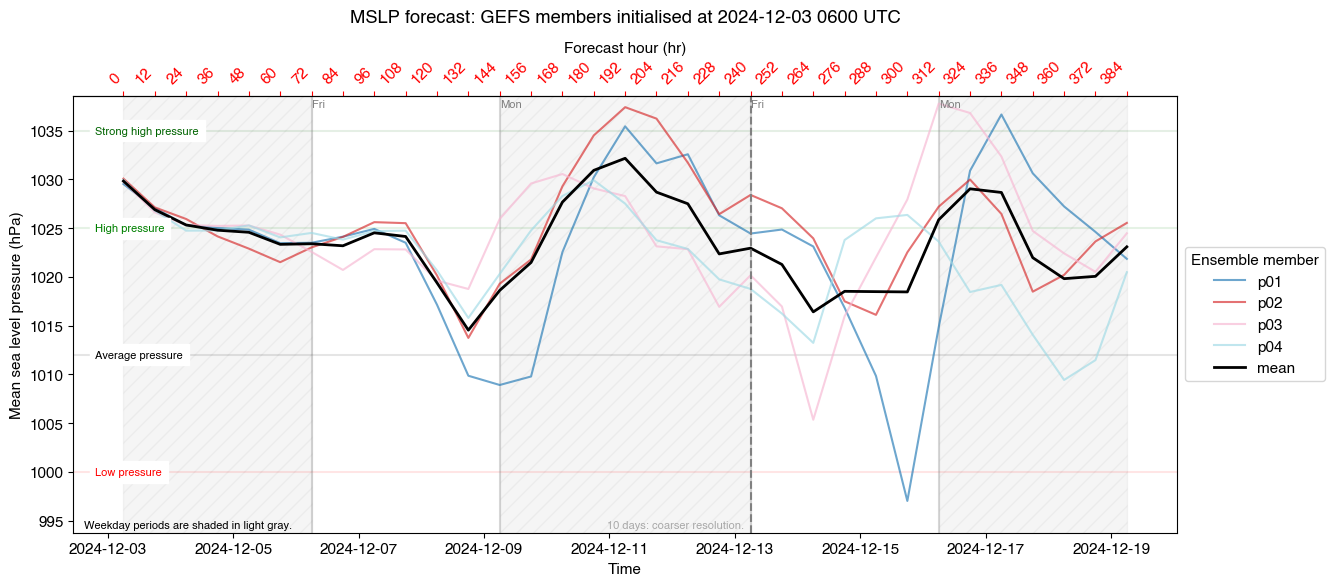

In [15]:
# assert "lisa" is "a nice person"

vrbl = 'mslp'
dfs_mslp = {m:0 for m in member_names}
for member in member_names:
    print(f"Processing member {member}")
    # Lat/lon used, not masks, though future may change
    mslp_ts = do_nwpval_mslp(INIT_DT['naive'], lat=ouray['lat'], lon=ouray['lon'],
                                member=member, delta_h=delta_h,
                                )
    print("Now creating forecast dataframe.")
    dfs_mslp[member] = create_forecast_dataframe(mslp_ts,
                                L.string_dict["mslp"]["array_name"],)

title = (f"MSLP forecast: GEFS members initialised at "
            f"{dfs_mslp[member_names[0]].index[0].strftime('%Y-%m-%d %H%M')} UTC")
fig,ax = plot_meteogram(dfs_mslp, L.get_key(vrbl,"array_name"), title=title,
                            plot_ensemble_mean=True)

# What's next?
We:
* Need to create Clyfar instances for each p** time series ("cly01", "cly02", etc)
* We will leave the control alone
* Aggregate percentile cuts from each Clyfar member's possibility distribution
* Need to parallelise
* Need to put forecast snow depth to initialise with obs, plus reset at zero

In [16]:
# Priority is creating a class to import Clyfar v1.0 FIS
# Then we can feed the inputs above
# We may need to work on repval functions to generate a daily value.
